## 線上資源
- mdgx introduction ([link](https://ambermd.org/tutorials/advanced/tutorial32/index.php))
- Group Meeting Google Drive ([link](https://drive.google.com/file/d/1qc4Dk0s59pbnqsGQYyiSj_ZMideWgyJl))
- Amber 2023 mounal ([link](https://ambermd.org/doc12/Amber23.pdf))

In [1]:
drug = "POH"

In [2]:
!mkdir conf1 iter1

mkdir: cannot create directory ‘conf1’: File exists
mkdir: cannot create directory ‘iter1’: File exists


### 建立scan每點zero-point energy所需的結構檔(.orca)

In [69]:
random.seed

NameError: name 'random' is not defined

In [75]:
%%writefile 2.1.GenConformers.py
from pymol import cmd
from numpy import random
import os

random.seed(0)
drug = "POH"
n_conf = 360
cpus = 8    ## using {cpus} cpus in parallel computing 
rams = 7000 ## using {rams} MB in computing
w_text = f'''\
! PAL{cpus}
! mp2 cc-pvdz TightSCF  NoKeepInts

%scf
  MaxCore {rams}
end
%mp2
  MaxCore {rams}
end
'''

cmd.load(f'../1.GenTopology/{drug}.mol2')
cmd.set('retain_order', 1)
cmd.alter('all', f"resn='{drug}'")
cmd.alter('all', "elem=''")
for i in range(1, n_conf+1):
    cmd.set_dihedral('name C12', 'name C11', 'name C3', 'name C4', i-random.rand())
    cmd.save(f'conf1/Conf{i}.pdb')
    os.system(f'obabel conf1/Conf{i}.pdb -o orcainp -O conf1/Conf{i}.orca')
    
    with open(f'conf1/Conf{i}.orca', 'r') as f:
        r_text = f.read()
        r_text = r_text[r_text.find('*'):]

    with open(f'conf1/Conf{i}.orca', 'w') as f:
        f.write(w_text+r_text)
exit()

Overwriting 2.1.GenConformers.py


In [76]:
!python3  2.1.GenConformers.py

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is conf1/Conf1.pdb)

1 molecule converted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is conf1/Conf2.pdb)

1 molecule converted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is conf1/Conf3.pdb)

1 molecule converted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is conf1/Conf4.pdb)

1 molecule converted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is conf1/Conf5.pdb)

1 molecule converted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is conf1/Conf6.pdb)

1 molecule converted
*** Open Babel Warning  in PerceiveBondO

### 執行orca 以計算 zero-point energy

In [5]:
%%writefile 2.2.Run_orca.slurm
#!/bin/bash
#SBATCH --partition=xeon                 # Define the partition on which the job shall run
#SBATCH --job-name=spOrca                # Job name
#SBATCH --ntasks=8                       # Total number of tasks
#SBATCH --nodes=1                        # Number of nodes on which to run
#SBATCH --cpus-per-task=1                # Threads per task
#SBATCH --mem=8000                       # Memory per job in MB
#SBATCH --output=spOrca.%J.out
#SBATCH --error=spOrca.%J.out
#SBATCH --array=1-360

scratchFile="/scratch/chu_02/allen/amber_gaff2"
confFilename=$(basename $(realpath .))
currentConfFile=$(pwd)
scratchConfFile="${scratchFile}/${confFilename}"
orca="$HOME/opt/orca-5.0.4/orca"

module load openmpi/gcc/64

mkdir -p ${scratchConfFile}
cp -r conf1/Conf${SLURM_ARRAY_TASK_ID}.orca ${scratchConfFile}

${orca} ${scratchConfFile}/Conf${SLURM_ARRAY_TASK_ID}.orca > ${scratchConfFile}/Conf${SLURM_ARRAY_TASK_ID}.oout

cp ${scratchConfFile}/Conf${SLURM_ARRAY_TASK_ID}.oout ${currentConfFile}/conf1
echo -e "# of primitive gaussian functions\n" >> ${currentConfFile} ## add mark to let 3.ExtractEnergies.mdgx can reconginze

Writing 2.2.Run_orca.slurm


In [ ]:
!sbatch 2.2.Run_orca.slurm

### 彙整所有zero-point energy的數值

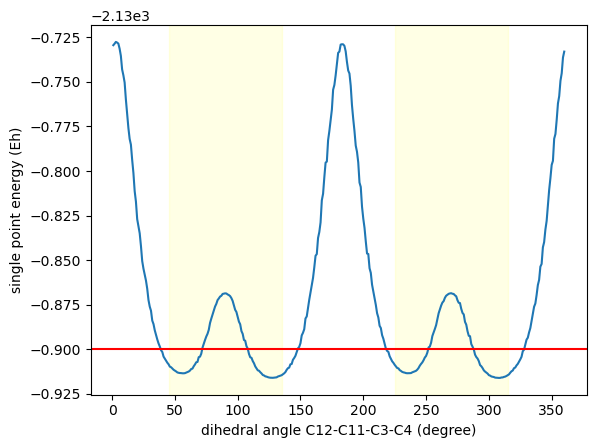

In [3]:
import re
import matplotlib.pyplot as plt

threshold = -2130.90 ## Eh

## Conf{i}.oout parse
energy_dict = {}
for i in range(1, 360+1):
    filename = f"conf1/Conf{i}.oout"
    with open(filename, "r") as file:
        for line in file:
            match = re.search(r"MP2 TOTAL ENERGY:\s+([-\d\.]+) Eh", line)
            if match:
                energy_dict[i] = float(match.group(1))
                break  # 找到後就跳出，避免不必要的讀取

plt.plot(energy_dict.keys(), energy_dict.values())
plt.axhline(threshold, c='r')
plt.axvspan( 45, 135, color='yellow', alpha=0.1)
plt.axvspan(225, 315, color='yellow', alpha=0.1)
plt.xlabel('dihedral angle C12-C11-C3-C4 (degree)')
plt.ylabel('single point energy (Eh)')
plt.show()

In [4]:
## 若重跑記得刪除原本output檔 concat.out, energies.dat, coords.cdf
!rm iter1/concat.out iter1/energies.dat iter1/coords.cdf

In [5]:
# oout_data = ''.join([f'  data     conf1/Conf{i}.oout \n' for i in range(1, 360+1) if energy_dict[i]<threshold])
oout_data = ''.join([f'  data     conf1/Conf{i}.oout \n' for i in list(range(45,136))+list(range(226,315))])
mdgx_script = f'''\
&files
  -p      ../1.GenTopology/{drug}.prmtop
  -o      iter1/concat.out
  -d      iter1/energies.dat
  -x      iter1/coords.cdf
&end

&speval
{oout_data}
&end
'''

!echo "{mdgx_script}" > 2.3.ExtractEnergies.mdgx
!mdgx -i 2.3.ExtractEnergies.mdgx

### Fit 力場參數

In [10]:
## 若重跑記得刪除原本output檔 fit.out, {drug}.dat, report.m
!rm iter1/fit.out iter1/{drug}.dat iter1/report.m

rm: cannot remove 'iter1/fit.out': No such file or directory
rm: cannot remove 'iter1/POH.dat': No such file or directory
rm: cannot remove 'iter1/report.m': No such file or directory


In [11]:
mdgx_script = f'''\
&files
  -parm   ../1.GenTopology/{drug}.all.modify.frcmod
  -d      iter1/{drug}.dat
  -o      iter1/fit.out
&end

&param
  System  ../1.GenTopology/{drug}.prmtop  iter1/coords.cdf  iter1/energies.dat
  ParmOutput frcmod
  eunits    hartree,
  accrep    iter1/report.m
  verbose    1,

  % Angle fitting input
  %fita       C* C* HA
  %FitAnglEq  1,
  %arst       0.0002,
  %arstcpl    1.0,

  % Torsion fitting input
  fith       CA CA CD CC
  hrst       0.0002,
&end
'''

!echo "{mdgx_script}" > 2.4.FitParm.mdgx
!mdgx -i 2.4.FitParm.mdgx

GetParamNamelist >> Warning.  Unrecognized restraint scaling method
GetParamNamelist >> ����U.  Valid methods are 'estimate' and 'spy.'
GetParamNamelist >> See the manual for descriptions.  The default
GetParamNamelist >> 'estimate' method remains in effect.

mdgx >> Unique adjustable parameters enumerated.
mdgx >>      1 conformations read.             
mdgx >> Parameter keys read.
mdgx >> 2 adjustable terms mapped.


In [8]:
!pwd

/home/work/projects/gqp/drugs/poh/test/2.Mdgx


#### fitting 結果
`iter1/repot.m` 檔在matlab執行可繪製fit圖 <br>
或是執行下方python code也可繪製相同fit圖 <br>
⚫ Original : 以原有的力場參數計算的Model Energy, 對上以zero-point energy計算的Target Energy <br>
🔴 Fitted   : 以fit過後的力場參數計算的Model Energy, 對上以zero-point energy計算的Target Energy, 兩能量數值越接近(x=y)代表fitted越好

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import re

# 讀取 MATLAB .m 檔案
with open("iter1/report.m", "r", encoding="utf-8") as f:
    lines = f.readlines()

# 解析 data0 部分的數據
pattern = re.compile(r"[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?")
data = []

recording = False
for line in lines:
    if "data0 = [" in line:
        recording = True
        continue
    if "]" in line and recording:
        break
    if recording:
        numbers = pattern.findall(line)
        if len(numbers) >= 4:
            data.append(list(map(float, numbers[:4])))

# 轉換為 NumPy 陣列
if data:
    data = np.array(data)
else:
    raise ValueError("No valid data found in report.m")

# 提取數據列
target, original, fitted = data[:, 0], data[:, 1], data[:, 2]

# 繪圖
plt.figure(figsize=(8, 6))
plt.plot(target, original, 'k.', label='Original')
plt.plot(target, fitted, 'r.', label='Fitted')
plt.xlabel('Target energy (kcal/mol)')
plt.ylabel('Model energy (kcal/mol)')
plt.title(f'Model results for {drug}.prmtop')
plt.legend()
plt.grid()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'iter1/report.m'

### Merge 兩個力場參數檔案 {drug}.all.modify.frcmod 以及 {drug}.dat

In [16]:
!cp ../1.GenTopology/{drug}.all.modify.frcmod iter1/{drug}.all.mdgx.frcmod

!sed -i '70d' iter1/{drug}.all.mdgx.frcmod
!sed -i '69d' iter1/{drug}.all.mdgx.frcmod

para = !sed -n '9p' iter1/{drug}.dat
!sed -i "68a {para[0]}" iter1/{drug}.all.mdgx.frcmod

para = !sed -n '10p' iter1/{drug}.dat
!sed -i "69a {para[0]}" iter1/{drug}.all.mdgx.frcmod

### 輸出 Amber 格式的座標檔案 (coordinate file, .rst7) 與參數檔案 (parameter file, .prmtop)

In [17]:
tleap_script = f'''\
{drug}=loadmol2 ../1.GenTopology/{drug}.mol2
loadamberparams iter1/{drug}.all.mdgx.frcmod
check ## just for check
saveamberparm {drug} iter1/{drug}.prmtop iter1/{drug}.rst7
quit
''' 

!echo "{tleap_script}" > 2.5.GenNewTop.tleap
!tleap -f 2.5.GenNewTop.tleap

-I: Adding /opt/anaconda3/envs/ambertools/dat/leap/prep to search path.
-I: Adding /opt/anaconda3/envs/ambertools/dat/leap/lib to search path.
-I: Adding /opt/anaconda3/envs/ambertools/dat/leap/parm to search path.
-I: Adding /opt/anaconda3/envs/ambertools/dat/leap/cmd to search path.
-f: Source 2.5.GenNewTop.tleap.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./2.5.GenNewTop.tleap
Loading Mol2 file: ../1.GenTopology/POH.mol2
Reading MOLECULE named POH
Loading parameters: ./iter1/POH.all.mdgx.frcmod
Reading force field modification type file (frcmod)
Reading title:
Remark line goes here
check: A maximum of two parameters are acceptable:
     a UNIT and an (optional) PARMSET.
Checking Unit.

/opt/anaconda3/envs/ambertools/bin/teLeap: Warning!
The unperturbed charge of the unit (3.999998) is not zero.

/opt/anaconda3/envs/ambertools/bin/teLeap: Note.
Ignoring the warning from Unit Checking.

Building topology.
Building atom parameters.
Building bond parameters.
Building angle p

### 匯出 Gromacs 格式的座標(.gro)、拓撲與參數檔案(.top)

In [128]:
!acpype -p iter1/{drug}.prmtop -x iter1/{drug}.rst7

| ACPYPE: AnteChamber PYthon Parser interfacE v. 2023.10.27 (c) 2025 AWSdS |
Converting Amber input files to Gromacs ...
==> Writing GROMACS files

==> Disambiguating lower and uppercase atomtypes in GMX top file, even if identical.

==> Writing GMX dihedrals for GMX 4.5 and higher.

Total time of execution: less than a second
